<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumCountriesClassifier_02_Naive_Bayes_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [4]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [5]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [6]:
def get_num_countries(x):
  if x is not None and type(x) is str:
    return len(x.split(","))
  return None

In [7]:
df_annotations["num_countries"] = df_annotations.country.apply(get_num_countries)

In [8]:
df_annotations["num_countries"].value_counts()

1.0     7998
2.0      726
3.0      341
4.0      263
5.0      230
6.0      225
7.0      193
8.0      176
10.0     155
9.0      137
11.0     135
12.0     116
13.0     109
14.0      92
15.0      90
17.0      78
18.0      68
16.0      65
21.0      57
20.0      56
19.0      54
23.0      47
22.0      44
24.0      35
25.0      31
26.0      27
29.0      22
30.0      21
27.0      20
31.0      19
28.0      18
32.0      17
33.0      14
41.0      11
34.0      11
38.0       8
39.0       8
37.0       7
43.0       7
36.0       6
35.0       6
44.0       6
40.0       6
48.0       6
47.0       3
42.0       2
49.0       2
50.0       2
45.0       1
58.0       1
46.0       1
62.0       1
51.0       1
54.0       1
Name: num_countries, dtype: int64

In [34]:
def get_num_countries_clean(num):
    if num is None or pd.isna(num):
      return None
    if num >= 2:
      return 1
    return 0
df_annotations["num_countries_clean"] = df_annotations["num_countries"].apply(get_num_countries_clean)

# Train and evaluate the number of countries extractor

In [35]:
df_train = df_annotations[(df_annotations.train_val == "train") & (~df_annotations.num_countries_clean.isna())]

In [36]:
df_val = df_annotations[df_annotations.train_val == "val"]

In [37]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline

In [38]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[a-z][a-z]+')
transformer = TfidfTransformer()

nb = ComplementNB()
model = make_pipeline(vectoriser, transformer, nb)

In [39]:
model.fit(df_train.text, df_train.num_countries_clean)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'au',
                                             'aura', 'aurai', 'auraient',
                                             'aurais', 'aurait', 'auras',
                                             'aurez', 'auriez', ...},
                                 token_pattern='[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('complementnb', ComplementNB())])

In [40]:
df_val["pred_num_countries"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
pred_num_countries = df_val["pred_num_countries"]

In [42]:
num_countries_ground_truths = df_val.num_countries_clean

In [43]:
acc = accuracy_score(num_countries_ground_truths.apply(str), pred_num_countries.apply(str))
print (f"Num countries accuracy {acc}")

Num countries accuracy 0.7299539170506912


''

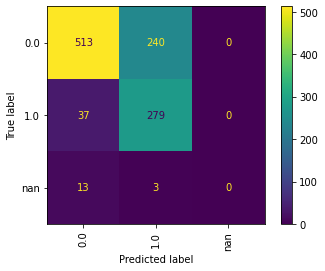

In [44]:
ConfusionMatrixDisplay.from_predictions(num_countries_ground_truths.apply(str), pred_num_countries.apply(str))
plt.xticks(rotation=90)
;

In [47]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(2):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")
        if ctr > 50:
          break

Strongest predictors for class 0

0	encounter
1	pubmed
2	gvhd
3	edu
4	unspecified
5	university
6	intraluminal
7	transplantation
8	nih
9	transplant
10	stem
11	project
12	cognitive
13	medicine
14	dsmb
15	artery
16	depression
17	journal
18	block
19	pi
20	side
21	tak
22	prostate
23	dr
24	sleep
25	pet
26	fracture
27	md
28	leukemia
29	alcohol
30	department
31	radiation
32	hemorrhage
33	discharge
34	office
35	percutaneous
36	experimental
37	muscle
38	individuals
39	pain
40	surgery
41	com
42	res
43	vascular
44	brain
45	recruitment
46	gov
47	http
48	team
49	pharmacy
50	insulin
51	registration
Strongest predictors for class 1

0	riz
1	reo
2	tho
3	hoffmann
4	atezolizumab
5	medi
6	roche
7	tio
8	pli
9	eti
10	merc
11	novartis
12	cu
13	nly
14	bms
15	gs
16	io
17	clean
18	ial
19	dmc
20	eot
21	ari
22	ro
23	tb
24	eudract
25	jec
26	mk
27	gmbh
28	ppd
29	lica
30	extension
31	su
32	imp
33	cci
34	ys
35	ltd
36	boehringer
37	ingelheim
38	prop
39	ass
40	ly
41	amended
42	esti
43	cts
44	pfizer
45	om
46	ub
47	orr
4

In [49]:
import bz2
with bz2.open("international_classifier.pkl.bz2", "wb") as f:
    pkl.dump(model, f)